<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML23_DZ7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание по теме «Ансамблирование» обновленное

**Цель**: применить на практике базовые ансамблевые методы

**Описание задания**:

В домашнем задании нужно решить задачу классификации наличия болезни сердца у пациентов. Данные для обучения моделей необходимо загрузить самостоятельно с сайта. Целевая переменная – наличие болезни сердца (HeartDisease), принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно. (Подробнее о признаках можно прочесть в описании датасета на сайте. Для выполнения работы не обязательно вникать в медицинские показатели.)

# 0. Установка пакетов, импорт библиотек и пользовательские функции

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00


Полезные ссылки:
по форматированию датафреймов https://habr.com/ru/articles/521894/
По автоматизации работы  с группой моделей https://github.com/ZakharovOleg/Machine-learning-projects/blob/master/MLA_regression.py

In [20]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.ensemble import  StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectPercentile, chi2
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую)

In [3]:
!pip install -q kaggle # Делаем 1 раз

In [4]:
# Это напоминалка - приглашение загрузить в сессионное хранилище свой kaggle.json. Ключ стерла
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marinabalakina","key":"0763a280a2e52ea690b44499c8ab213e"}'}

In [5]:
! mkdir ~/.kaggle # Создаем каталог .kaggle  1 раз, для того, чтобы сюда положить ключ kaggle.json, который получаем на Kaggle при регистрации

In [6]:
! cp kaggle.json ~/.kaggle/  # кладем ключ

In [7]:
! chmod 600 /root/.kaggle/kaggle.json # засекречиваем. К сожалению, это все только на время сеанса

In [8]:
!kaggle datasets list -s 'heart' # Сюда вместо happiness - люббое ключевое слово

ref                                                           title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
andrewmvd/heart-failure-clinical-data                         Heart Failure Prediction                          4KB  2020-06-20 01:03:20         108229       1948  1.0              
fedesoriano/heart-failure-prediction                          Heart Failure Prediction Dataset                  9KB  2021-09-10 18:11:57          97797       2090  1.0              
johnsmith88/heart-disease-dataset                             Heart Disease Dataset                             6KB  2019-06-06 15:33:55          78515        630  0.88235295       
rashikrahmanpritom/heart-attack-analysis-prediction-dataset   Heart Attack Analysis & Pred

In [9]:
!kaggle datasets download -d 'fedesoriano/heart-failure-prediction'  # А это нужный датасет

  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 5.50MB/s]


In [10]:
!unzip heart-failure-prediction.zip

Archive:  heart-failure-prediction.zip
  inflating: heart.csv               


In [11]:
df = pd.read_csv('/content/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [12]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#2. Подготовьте датасет к обучению моделей.

In [13]:
df.info() # пропусков типа nan нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [14]:
# проверим, нет ли пропусков, обозначенных "?" 
flag=True
for column in df.columns:
  if('?')  in list(df[column].value_counts()):
    print(column)
    flag = False
if flag:
    print('пропусков "?" нет')

пропусков "?" нет


## b) *Постройте 1-2 графика на выбор

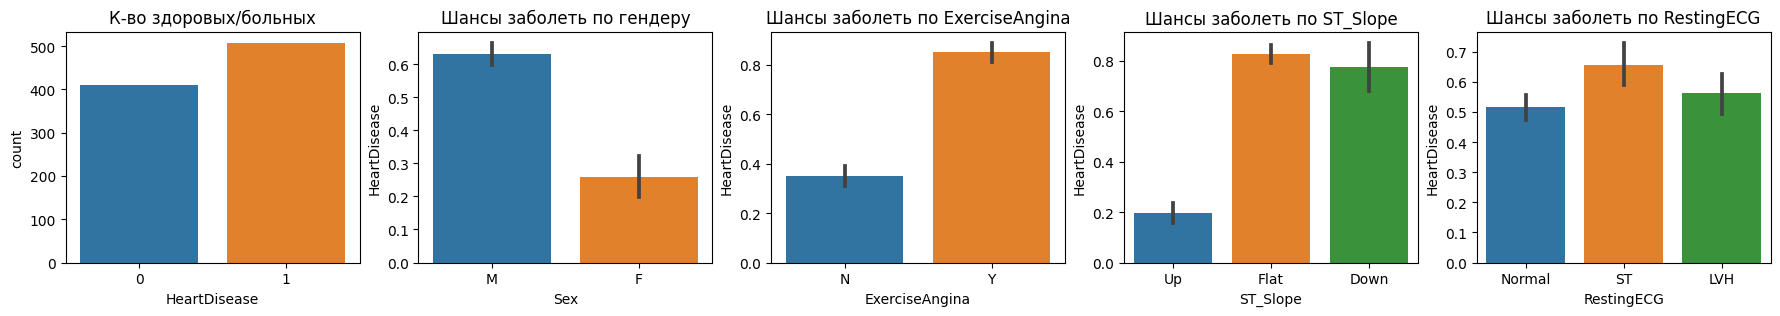

In [15]:
# Посмотрим на соотношение меток классов в HeartDisease 
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(22,3))

_ = sns.countplot(x='HeartDisease', data=df, ax=ax[0])
ax[0].set_title('К-во здоровых/больных')
_ = sns.barplot(x='Sex', y='HeartDisease', data=df, ax=ax[1])
ax[1].set_title('Шансы заболеть по гендеру')
_ = sns.barplot(x='ExerciseAngina', y='HeartDisease', data=df, ax=ax[2])

ax[2].set_title('Шансы заболеть по ExerciseAngina')
_ = sns.barplot(x='ST_Slope',y='HeartDisease',data=df, ax=ax[3])
ax[3].set_title('Шансы заболеть по ST_Slope')
_ = sns.barplot(x='RestingECG',y='HeartDisease',data=df, ax=ax[4])
ax[4].set_title('Шансы заболеть по RestingECG')

plt.show()
plt.close()

## a)Категориальные переменные переведите в цифровые значения.

In [32]:
# Категориальные features - определяем по типу object. Вместе с target их 9
cat_features = df.select_dtypes("object").columns.tolist()
print(*cat_features, sep=", ")

Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope


In [33]:
num_features = df.select_dtypes(['int', 'float']).columns.tolist()
print(*num_features, sep=", ")


Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease


#3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

#4. Обучите дерево решений на обучающем множестве. 

#5. Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report.

In [84]:
# Настройка параметров оценивания алгоритма
random_seed=0
num_folds = 9
n_iter = 1000
n_estimators = 100
scoring = 'r2'
X = df.drop(columns=['HeartDisease'])
y=df['HeartDisease']
target_names = ['healthy', 'sick']

In [85]:
# Формирование списка алгоритмов
models = []
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('BGC', BaggingClassifier()))
models.append(('SCC', StackingClassifier(
     [
                                      ('DTS', DecisionTreeClassifier()),
                                      ('RFC',  RandomForestClassifier()),
                                     ],  
                                      LinearSVC(C=1, random_state=random_seed) 
)))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('LGBMC', LGBMClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('CBC', CatBoostClassifier()))


In [86]:
# Пайплайн трансформации числовых и категориальных признаков
num_features =['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
numeric_transformer = Pipeline(
    steps=[ ("scaler", Normalizer())]
)


categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)  

In [87]:
##############################################################################
# Блиц-проверка алгоритмов на нормализованных исходных данных
# (функция Normalizer)
pipelines = []
pipelines.append(('SS_DTS', Pipeline([("preprocessor", preprocessor),
                                    ('DTS', DecisionTreeClassifier())])))

pipelines.append(('SS_RFC', Pipeline([("preprocessor", preprocessor),
                                     ('RFC', RandomForestClassifier())])))

pipelines.append(('SS_BGS', Pipeline([("preprocessor", preprocessor),
                                     ('BGC', BaggingClassifier())])))

pipelines.append(('SS_GBC', Pipeline([("preprocessor", preprocessor),
                                      ('GBC', GradientBoostingClassifier())])))

pipelines.append(('SS_ABC', Pipeline([("preprocessor", preprocessor),
                                      ('ABC', AdaBoostClassifier())])))

pipelines.append(('SS_LGBMC', Pipeline([("preprocessor", preprocessor),
                                      ('LGBMC', LGBMClassifier())])))

pipelines.append(('SS_XGBC', Pipeline([("preprocessor", preprocessor),
                                    ('XGBC', XGBClassifier())])))

pipelines.append(('SS_SCC', Pipeline([("preprocessor", preprocessor),
                                     ('SCC', StackingClassifier([
                                      ('DTS', DecisionTreeClassifier()),
                                      ('RFC',  RandomForestClassifier())],  
                                      LinearSVC(C=1, random_state=random_seed)))])))

pipelines.append(('SS_CBC', Pipeline([("preprocessor", preprocessor),
                                      ('CBC', CatBoostClassifier(
                                         verbose=False
                                      ))])))


In [88]:
# Оценивание эффективности выполнения каждого алгоритма
scores_N = []
names_N = []
results_N = []
predictions_N = []
msg_N = []
results = {}

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
    names_N.append(name)
    # model
    X = df.drop(columns=['HeartDisease'])
    y=df['HeartDisease']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    m_fit = model.fit(X_train, y_train)
    m_predict = model.predict(X_test)
    predictions_N.append(m_predict)
    m_score = model.score(X_test, y_test)
    scores_N.append(m_score)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=
                                 scoring)
    results_N.append(cv_results)
    msg = "%s: train = %.3f (%.3f) / test = %.3f" % (name, cv_results.mean(),
                           cv_results.std(), m_score)
    msg_N.append(msg)
    print(f"Classification report {name}\n")
    print('====================================================================')

    print(f"{classification_report(y_test, m_predict, target_names=target_names)}\n")
    # print(msg)
    # a=classification_report(y_test, m_predict, target_names=target_names, output_dict=True )['weighted avg']
    a=classification_report(y_test, m_predict, target_names=target_names, output_dict=True )['sick']
    results[f'{name}']=a

Classification report SS_DTS

              precision    recall  f1-score   support

     healthy       0.77      0.78      0.77        77
        sick       0.84      0.83      0.84       107

    accuracy                           0.81       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.81      0.81       184


Classification report SS_RFC

              precision    recall  f1-score   support

     healthy       0.85      0.78      0.81        77
        sick       0.85      0.90      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184


Classification report SS_BGS

              precision    recall  f1-score   support

     healthy       0.81      0.81      0.81        77
        sick       0.86      0.86      0.86       107

    accuracy                           0.84       184
   macro avg       0.83      0.83   

#9. Сформулируйте выводы по проделанной работе.

a) Сравните метрики построенных моделей.

In [92]:
res=pd.DataFrame.from_dict(results)
res.drop('support', axis=0, inplace=True)
# res.head().style.format('{:.4f}', na_rep='-').highlight_max(color='yellowgreen') .highlight_min(color='coral')
res.head().style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues', axis=1)

,SS_DTS,SS_RFC,SS_BGS,SS_GBC,SS_ABC,SS_LGBMC,SS_XGBC,SS_SCC,SS_CBC
precision,0.8396,0.8496,0.8598,0.8692,0.8364,0.8835,0.8762,0.8559,0.8679
recall,0.8318,0.8972,0.8598,0.8692,0.8598,0.8505,0.8598,0.8879,0.8598
f1-score,0.8357,0.8727,0.8598,0.8692,0.8479,0.8667,0.8679,0.8716,0.8638


b) Напишите свое мнение, какая модель наилучшая и почему.

ClASSIFICATION_REPORT содержит метрики отдельно для каждого класса. Т.к у нас медицинская задача, то в первую очередь будут важны метрики для класса больных ('sick'), и сравнение моделей будет выполняться по ним
Все рассмотренные в работе модели продемонстрировали неплохое качество - более  83%. Чуть ниже, чем у остальных, оказались метрики у DecisionTreeClassifier, что неудивительно, учитывая, что все остальные модели - это разные ансамбли,использующие бэггинг, стекинг и бустинг. 
Все модели работали в одинаковых условиях, без тонкой настроки по гиперпараметрам, что говорит о том, что на данном датасете их потенциал раскрыт не полностью.

Наилучшие результаты по precision показала модель SS_LGBMC (0.8835), по recall -  RandomForestClassifier (0.8972). RandomForestClassifier опережает конкурентов также по f1-score(0.8727), поэтому - это лидер среди нетюнингованных классификаторов на нашем датасете.
